# Data Pre-processing Notebook

This notebook contains the data pre-processing steps before model training. It includes:

**Data Cleaning**
- Sample Removal
- Error Margins Removal

**Encoding**
- Secondary Structure
- Reversibility

**Null Handling**

**Correlation Functions**

**Train-Test Split**
- Phase 1
- Phase 2

## Setup
1. To install the required packages, run:
```
pip install -r requirements.txt
```

2. (Optional) If you want to download the UniProt database, run:
```
python utils/download_uniprot.py
```

3. (Optional) If you want to extract protein sequences for raw_data.tsv, run:
```
python utils/seq_extract.py
```
This will create protein_seq.tsv with the extracted sequences from UniProt IDs.

In [1]:
import pandas as pd
import numpy as np
import re
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.basic_statictical.historams import histogram
from utils.basic_statictical.seq_distribution import sequence_length_distribution
from utils.basic_statictical.correlations import pearson_correlation_heatmap, spearman_correlation_heatmap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seq_extracted = "../datasets/raw/merged_dataset.tsv"
dataset = "../datasets/protein_dataset.tsv"
all_features = "../datasets/features.csv"

## Data Cleaning: Sample Removal

In [2]:
# Remove duplicates
df = pd.read_csv(seq_extracted, sep="\t", low_memory=False)

total_rows = len(df)

df_no_duplicates = df.drop_duplicates(keep="last")
rows_after_dedup = len(df_no_duplicates)
duplicates_removed = total_rows - rows_after_dedup

df_no_duplicates.to_csv(dataset, sep="\t", index=False)

print(f"Total rows before deduplication: {total_rows}")
print(f"Total rows after deduplication: {rows_after_dedup}")
print(f"Number of duplicate rows removed: {duplicates_removed}")

Total rows before deduplication: 119528
Total rows after deduplication: 79355
Number of duplicate rows removed: 40173


In [3]:
# Remove rows with no sequence
df = pd.read_csv(dataset, sep="\t", low_memory=False)
total_rows = len(df)

df_filtered = df.dropna(subset=["Protein_Sequence"])
df_filtered = df_filtered[df_filtered["Protein_Sequence"].str.strip() != "-"]

filtered_rows = len(df_filtered)
removed_rows = total_rows - filtered_rows

df_filtered.to_csv(dataset, sep="\t", index=False)

print(f"Total rows in original file: {total_rows}")
print(f"Rows removed (no sequence): {removed_rows}")
print(f"Rows remaining: {filtered_rows}")
print(f"Filtered data saved to {dataset}")

Total rows in original file: 79355
Rows removed (no sequence): 2634
Rows remaining: 76721
Filtered data saved to ../datasets/protein_dataset.tsv


Long sequences will cause runtime issues in the embedding process.
There is just one very long sequence in the dataset with 34000 amino acids, so we can remove it.

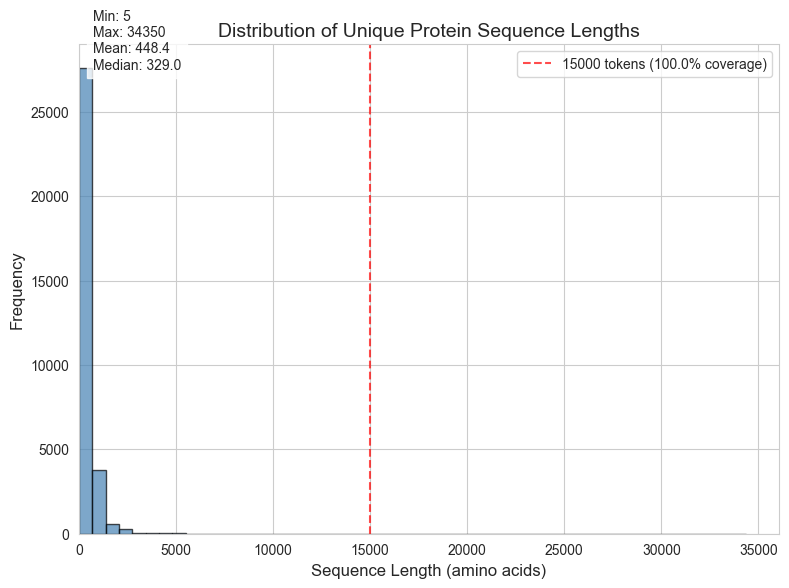

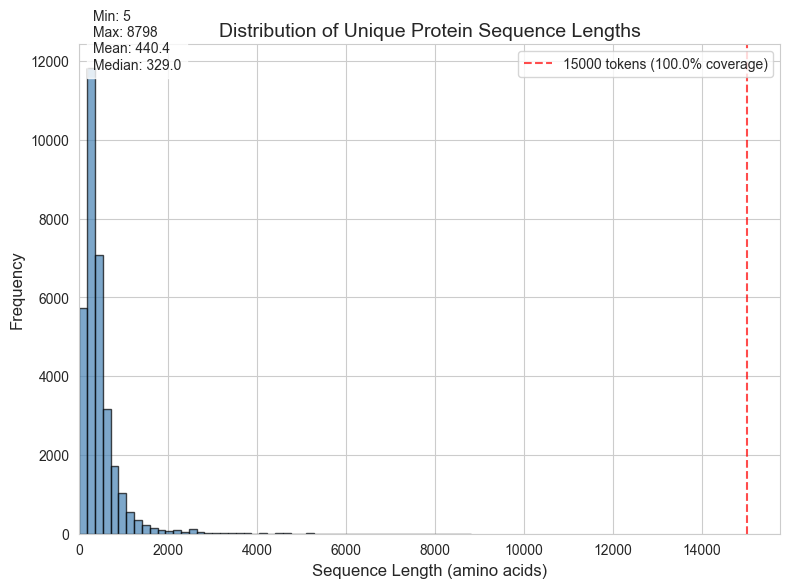

Total sequences: 76722
Sequences within length limit (15000): 76678
Sequences removed: 44 (0.06%)

Unique sequences before filtering: 32365
Unique sequences after filtering: 32357
Unique sequences removed: 8 (0.02%)


In [4]:
# Remove sequences longer than max_length
max_length = 15000
sequence_length_distribution(dataset, max_length)

df = pd.read_csv(dataset, sep='\t', header=None, low_memory=False)

sequence_col = df.iloc[:, -1]
sequence_lengths = sequence_col.str.len()
filtered_df = df[sequence_lengths <= max_length]

filtered_df.to_csv(dataset, sep='\t', header=False, index=False)

sequence_length_distribution(dataset, max_length)

total_sequences = len(df)
filtered_sequences = len(filtered_df)
removed_sequences = total_sequences - filtered_sequences

unique_sequences_before = sequence_col.nunique()
unique_sequences_after = filtered_df.iloc[:, -1].nunique()
unique_sequences_removed = unique_sequences_before - unique_sequences_after

print(f"Total sequences: {total_sequences}")
print(f"Sequences within length limit ({max_length}): {filtered_sequences}")
print(f"Sequences removed: {removed_sequences} ({removed_sequences/total_sequences*100:.2f}%)")

print(f"\nUnique sequences before filtering: {unique_sequences_before}")
print(f"Unique sequences after filtering: {unique_sequences_after}")
print(f"Unique sequences removed: {unique_sequences_removed} ({unique_sequences_removed/unique_sequences_before*100:.2f}%)")


## Data Cleaning: Error Margins Removal

Some numerical values in the dataset include error margins in parentheses.


For example: "123 (12)" indicates a value of 123 with an error of ±12.


To simplify the data, we remove the error margins and keep only the main values.

In [5]:
df = pd.read_csv(dataset, sep="\t", low_memory=False)

def clean_value(value):
    if isinstance(value, str):
        if value.strip() == "-":
            return value

        if "(" in value:
            return value.split("(")[0].strip()
    return value


df_clean = df.copy()

columns_to_clean = []
for col in df_clean.columns:
    if df_clean[col].astype(str).str.contains(r"\(.*\)").any():
        columns_to_clean.append(col)

print(
    f"Found {len(columns_to_clean)} columns with bracket values: {columns_to_clean}"
)

for col in columns_to_clean:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_value)
        
        if col not in ["STATE", "REVERSIBILITY", "SEC_STR", "UniProt_ID", "PDB_wild"]:
            df_clean[col] = df_clean[col].apply(
                lambda x: pd.to_numeric(x, errors="coerce") if x != "-" else x
            )

print("\nCleaned values:")
for col in df.columns:
    orig_values = df[col].astype(str).str.contains(r"\(\d+\.?\d*\)")
    if orig_values.any():
        idx = orig_values.idxmax()
        print(
            f"Column {col} - Original: {df[col][idx]} → Cleaned: {df_clean[col][idx]}"
        )

df_clean = df_clean.fillna("-")
df_clean.to_csv(dataset, sep="\t", index=False, na_rep="-")
print(f"\nCleaned dataset saved to {dataset}")

Found 12 columns with bracket values: ['Tm_(C)', '∆Tm_(C)', '∆H_(kcal/mol)', '∆Cp_(kcal/mol)', '∆HvH_(kcal/mol)', '∆G_(kcal/mol)', '∆∆G_(kcal/mol)', 'm_(kcal/mol/M)', 'Cm_(M)', '∆G_H2O_(kcal/mol)', '∆∆G_H2O_(kcal/mol)', 'REVERSIBILITY']

Cleaned values:
Column Tm_(C) - Original: 58.7(0.7) → Cleaned: 58.7
Column ∆Tm_(C) - Original: 61.9 (0.4) → Cleaned: 61.9
Column ∆H_(kcal/mol) - Original: 15.8 (0.29) → Cleaned: 15.8
Column ∆Cp_(kcal/mol) - Original: -1.44 (0.24) → Cleaned: -1.44
Column ∆HvH_(kcal/mol) - Original: 104 (0.49) → Cleaned: 104
Column ∆G_(kcal/mol) - Original: 9.81 (0.18) → Cleaned: 9.81
Column ∆∆G_(kcal/mol) - Original: -0.76 (0.9) → Cleaned: -0.76
Column m_(kcal/mol/M) - Original: 1.7 (0.2) → Cleaned: 1.7
Column Cm_(M) - Original: 1.86(0.01) → Cleaned: 1.86
Column ∆G_H2O_(kcal/mol) - Original: 2.95 (0.19) → Cleaned: 2.95
Column ∆∆G_H2O_(kcal/mol) - Original: 0.62 (0.06) → Cleaned: 0.62
Column REVERSIBILITY - Original: yes(0.94) → Cleaned: yes

Cleaned dataset saved to ../

## Encoding: Secondary Structure

**cleaning the SEC_STR column:**

There is one entry with SEC_STR value = -4.38, which is not a valid secondary structure.
After checking the data, it seems to be a mistake in the data collection process. The relevant entries are as follows:

| PDB_ID | UniProt_ID | PDB_wild | SEC_STR |
|--------|------------|-----------|---------|
| 27495  | P06654     | 1PGA     | Coil    |
| 27496  | P06654     | 1PGA     | Coil    |
| 27497  | P06654     | 1PGA     | -4.38   |
| 27498  | P29160     | 3N4Y     | -     |

accourding to the neighbouring entries, the correct SEC_STR value should be "Coil".

In [6]:
df = pd.read_csv(dataset, sep='\t', low_memory=False)

found = False
for idx, row in df.iterrows():
    if row['SEC_STR'] == '-4.38':
        df.at[idx, 'SEC_STR'] = "Coil"
        found = True

if found:
    df.to_csv(dataset, sep='\t', index=False)
    print("File saved with the corrected SEC_STR value.")
else:
    print("No entry found with SEC_STR value = -4.38")

File saved with the corrected SEC_STR value.


**Count-Based Encoding of Secondary Structure:**

There are 4 secondary structure types: `Coil, Helix, Sheet, Turn`

Each sample has a number of each secondary structure type, we can count the number of types and represent it as a vector.

**Encoded vector:** `[Coil-count, Helix-count, Sheet-count, Turn-count]`

In [7]:
COIL = 0
HELIX = 1
SHEET = 2
TURN = 3


def encode_secondary_structure(structure_text):
    if not structure_text or structure_text == "-":
        return [0, 0, 0, 0]

    counts = [0, 0, 0, 0]
    structures = [s.strip() for s in structure_text.split(",")]

    for structure in structures:
        if "Coil" in structure:
            counts[COIL] += 1
        elif "Helix" in structure:
            counts[HELIX] += 1
        elif "Sheet" in structure:
            counts[SHEET] += 1
        elif "Turn" in structure:
            counts[TURN] += 1

    return counts


df = pd.read_csv(dataset, sep="\t", low_memory=False)
df["SEC_STR_ENCODED"] = df["SEC_STR"].apply(encode_secondary_structure)
df.to_csv(dataset, sep="\t", index=False)

print("\nSecondary Structure Types and Their Encodings:")
print("-" * 50)
print(f"{'Secondary Structure':<25} {'Count-Based Encoding'}")
print("-" * 50)

examples = [
    "Coil",
    "Helix",
    "Sheet",
    "Turn",
    "Helix, Sheet",
    "Helix, Turn, Turn",
    "-",
]

for example in examples:
    encoding = encode_secondary_structure(example)
    print(f"{example:<25} {encoding}")


Secondary Structure Types and Their Encodings:
--------------------------------------------------
Secondary Structure       Count-Based Encoding
--------------------------------------------------
Coil                      [1, 0, 0, 0]
Helix                     [0, 1, 0, 0]
Sheet                     [0, 0, 1, 0]
Turn                      [0, 0, 0, 1]
Helix, Sheet              [0, 1, 1, 0]
Helix, Turn, Turn         [0, 1, 0, 2]
-                         [0, 0, 0, 0]


## Encoding: Reversibility

The reversibility values are mostly `yes` or `no` booleans so we mapped them to numerical values between -1 and 1:
- "yes" -> 1.0 (fully reversible)
- "no" -> 0.0 (not reversible) 
- "unknown"/"unknownnouwn" -> -1.0 (unknown status)
- "partially reversible" -> 0.5 (half reversible)
- "yes, 90%" -> 0.9 (90% reversible)
- "70% reversible" -> 0.7 (70% reversible)
- "> 90%" -> 0.95 (more than 90% reversible)


In [8]:
df = pd.read_csv(dataset, sep='\t', low_memory=False)

def map_reversibility(value):
    if isinstance(value, str):
        if value.lower() == "yes":
            return 1.0
        elif value.lower() == "no":
            return 0.0
        elif value.lower() in ["unknown", "unknownnouwn"] :
            return -1.0
        elif value.lower() == "partially reversible":
            return 0.5
        elif value.lower() == "yes, 90%":
            return 0.9
        elif value.lower() == "70% reversible":
            return 0.7
        elif value.lower() == "> 90%":
            return 0.95
    return value

df['REVERSIBILITY'] = df['REVERSIBILITY'].apply(map_reversibility)

df.to_csv(dataset, sep='\t', index=False)
print("File saved with the updated REVERSIBILITY values.")

File saved with the updated REVERSIBILITY values.


## Null Handling

In [9]:
# Show the null values count and percentage in the dataset
df = pd.read_csv(dataset, sep="\t", low_memory=False, na_values=["-"])

total_rows = len(df)

null_counts = df.isna().sum()
non_null_counts = df.notna().sum()

null_percentages = (null_counts / total_rows * 100).round(2)
non_null_percentages = (non_null_counts / total_rows * 100).round(2)

results = pd.DataFrame(
    {
        "Null Count": null_counts,
        "Null %": null_percentages,
        "Non-Null Count": non_null_counts,
        "Non-Null %": non_null_percentages,
    },
    index=df.columns,
)

print(results)

                    Null Count  Null %  Non-Null Count  Non-Null %
UniProt_ID               33927   44.25           42750       55.75
PDB_wild                 49937   65.13           26740       34.87
SEC_STR                  46866   61.12           29811       38.88
ASA                      49142   64.09           27535       35.91
pH                        2466    3.22           74211       96.78
T_(C)                    62634   81.69           14043       18.31
Tm_(C)                   22013   28.71           54664       71.29
∆Tm_(C)                  66604   86.86           10073       13.14
∆H_(kcal/mol)            71728   93.55            4949        6.45
∆Cp_(kcal/mol)           73612   96.00            3065        4.00
∆HvH_(kcal/mol)          71585   93.36            5092        6.64
∆G_(kcal/mol)            75295   98.20            1382        1.80
∆∆G_(kcal/mol)           63024   82.19           13653       17.81
m_(kcal/mol/M)           69524   90.67            7153        

Some features have a lot of null values, in the following we just use features with less than 75% null values including:

- ASA
- pH
- T_(C)
- Tm_(C)
- m_(kcal/mol/M)
- Cm_(M)
- ∆G_H2O_(kcal/mol)
- REVERSIBILITY
- SEC_STR_ENCODED
- Protein_Sequence

**Null Handlig Strategies:**
- `pH & T:` These are experimental conditions and most experiments were conducted under neutral conditions and room temperature (pH = 7, T = 25°C), so Null values are set as the `mode`.

- `REVERSIBILITY:` The value -1 in the REVERSIBILITY field already denotes "unknown", so the `flag -1 `is used for nulls.

- `ASA:` The null features of ASA is also assigned a `flag -1`.

Note that for `other thermodynamic features` the `Phase-1 models` will predict null values.

Histograms of features are shown before and after null handling:

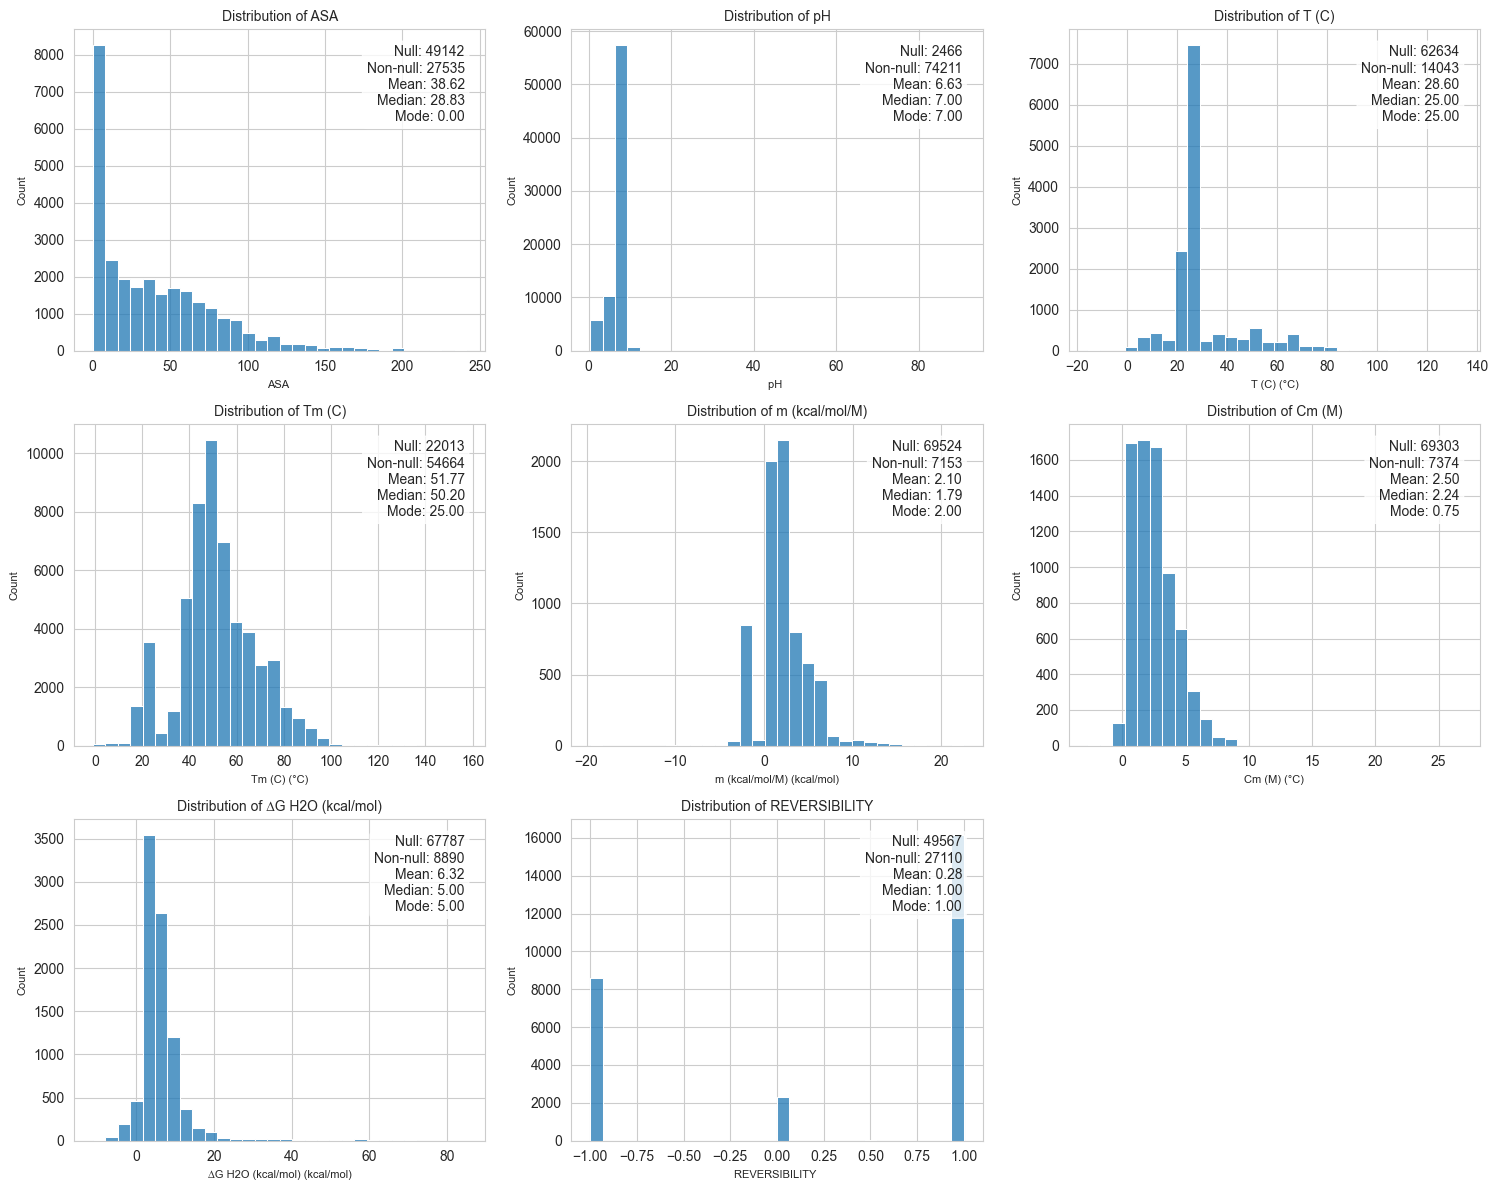

Null values have been handled successfully!


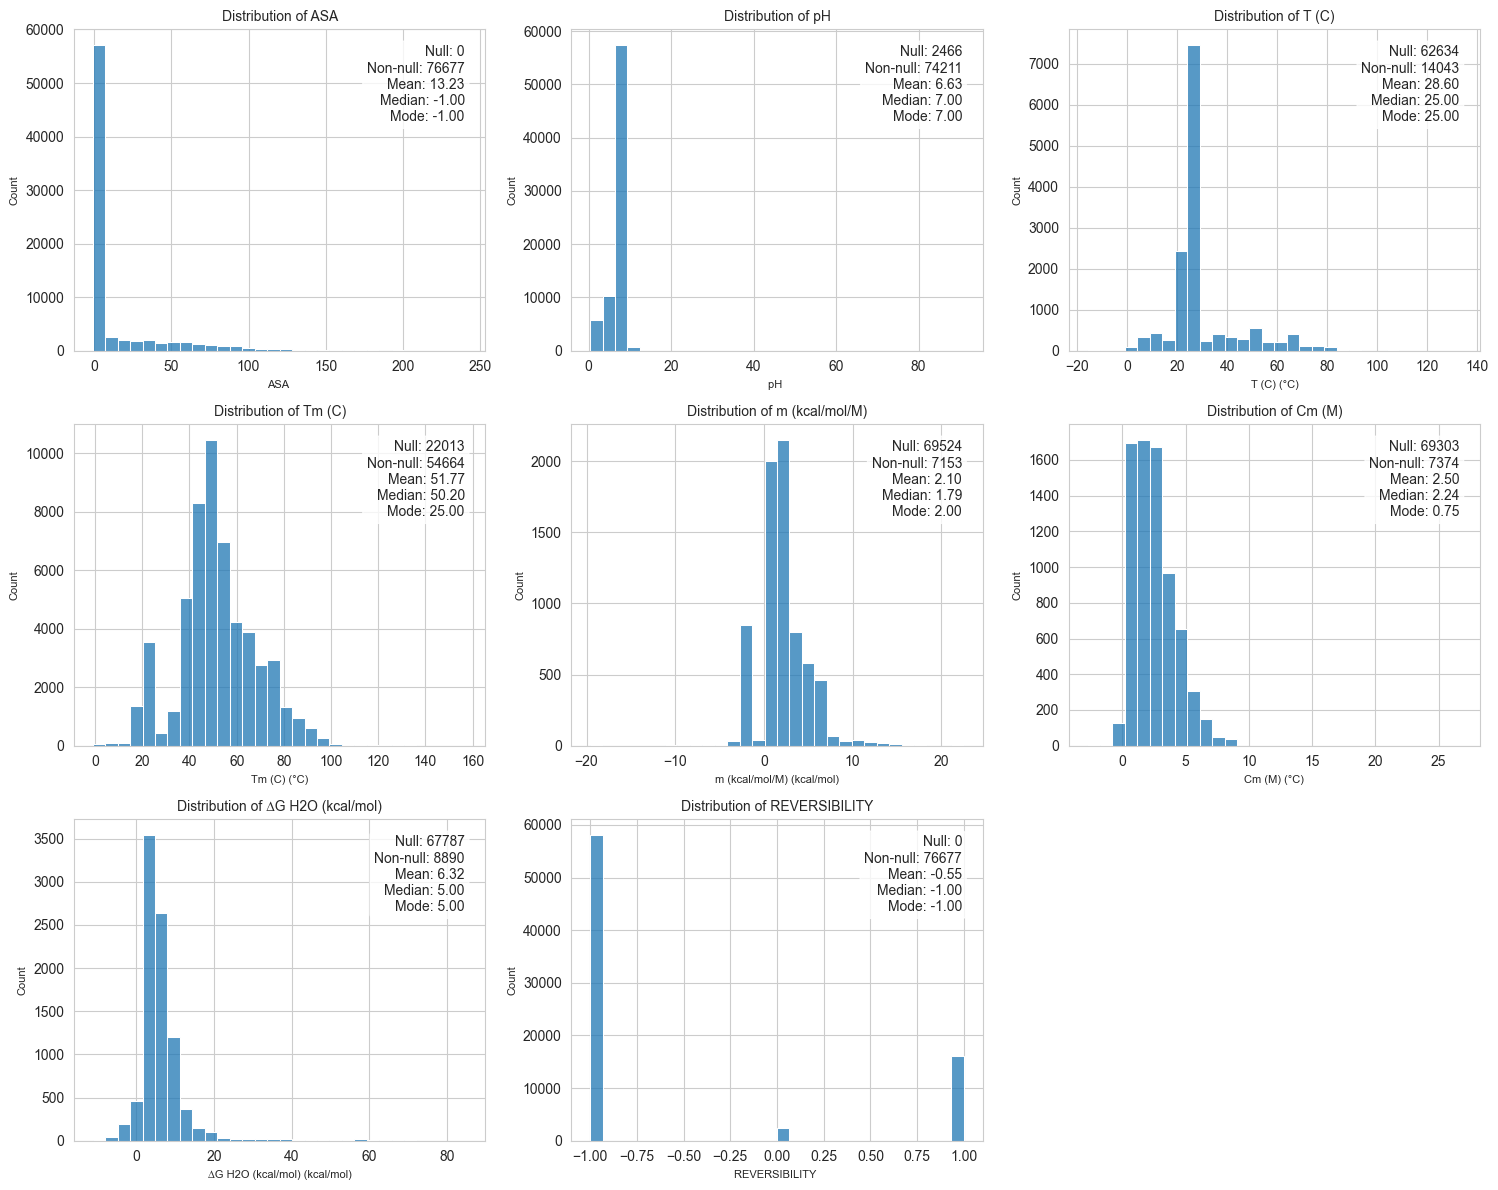

In [10]:
dataset = "../datasets/protein_dataset.tsv"
histogram(dataset)

df = pd.read_csv(dataset, sep="\t", low_memory=False)

df.replace("-", np.nan, inplace=True)

df["ASA"] = df["ASA"].fillna(-1)    # Flag
df["REVERSIBILITY"] = df["REVERSIBILITY"].fillna(-1)    # Flag

df["ASA"] = df["ASA"].astype(float)
df["REVERSIBILITY"] = df["REVERSIBILITY"].astype(float)

df.to_csv(dataset, sep="\t", index=False)
print(f"Null values have been handled successfully!")
histogram(dataset)

In [ ]:
df["pH"] = df["pH"].fillna(7.0)    # Mode 
df["T_(C)"] = df["T_(C)"].fillna(25.0)    # Mode

df["pH"] = df["pH"].astype(float)
df["T_(C)"] = df["T_(C)"].astype(float)

## Correlation Functions

`Pearson` correlation is used to measure `linear` relationships between variables, while `Spearman` correlation is used to assess `monotonic` (rank-based) relationships.

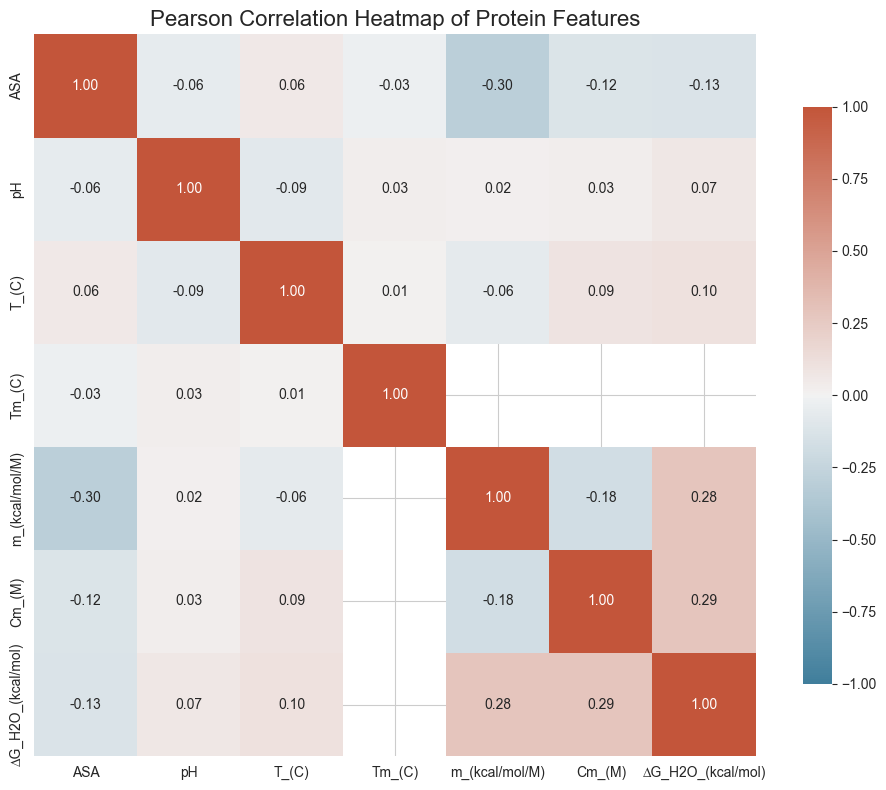

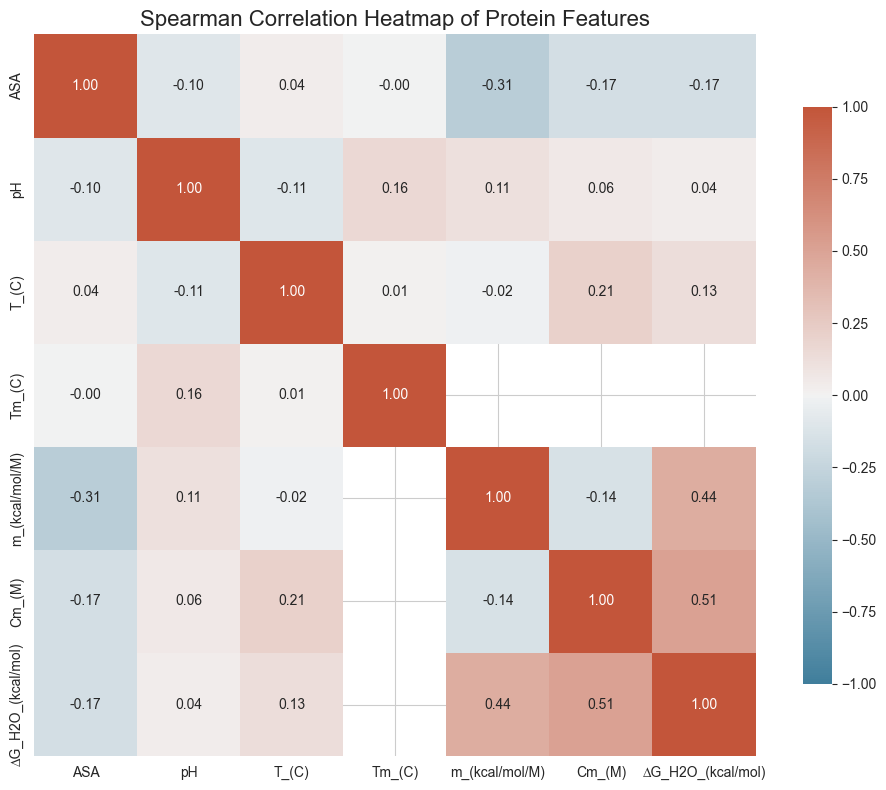

In [21]:
pearson_correlation_heatmap(dataset)
spearman_correlation_heatmap(dataset)

## Train-Test Split: Phase 1

Before proceeding, please refer to `embedding.ipynb` for creating sequence embeddings file.

This script combines all features used to train models in both phases, into one file.

**All Features**
   - Basic features: `ASA`, `pH`, `T_(C)`
   - Secondary structure: `Coil`, `Helix`, `Sheet`, `Turn`
   - Stability metrics: `Tm_(C)`, `m_(kcal/mol/M)`, `Cm_(M)`, `∆G_H2O_(kcal/mol)`
   - Protein embeddings: 320 dimensions (`embed_0` to `embed_319`)

**Output File**
   - `features.csv`: Combined dataset

Final shape: Rows = protein records, Columns = 331 features (11 properties + 320 embeddings)

In [10]:
embeddings_file = "../datasets/sequence_embeddings.csv"

df = pd.read_csv(dataset, sep="\t", low_memory=False)
embeddings_df = pd.read_csv(embeddings_file)

embeddings_df["Embedding"] = embeddings_df["Embedding"].apply(
    lambda x: np.array([float(num) for num in re.findall(r"-?\d+\.?\d*e?[-+]?\d*", x)])
)

features = []
print(f"Processing {len(df)} protein records...")

for i, (_, row) in enumerate(df.iterrows()):
    if i % 10000 == 0:
        print(f"Processing record {i}/{len(df)}...")
    
    asa = row["ASA"]
    ph = row["pH"]
    temp = row["T_(C)"]
    
    tm = row["Tm_(C)"] if not pd.isna(row["Tm_(C)"]) else None
    m_value = row["m_(kcal/mol/M)"] if not pd.isna(row["m_(kcal/mol/M)"]) else None
    cm = row["Cm_(M)"] if not pd.isna(row["Cm_(M)"]) else None
    delta_g_h2o = row["∆G_H2O_(kcal/mol)"] if not pd.isna(row["∆G_H2O_(kcal/mol)"]) else None

    sec_str_encoded = eval(row["SEC_STR_ENCODED"])

    protein_seq = row["Protein_Sequence"]
    embedding_row = embeddings_df[embeddings_df["Protein_Sequence"] == protein_seq]

    if not embedding_row.empty:
        embedding = embedding_row["Embedding"].values[0]
    else:
        print(f"No embedding found for protein sequence: {protein_seq}")
        embedding = np.zeros(320)

    feature_vector = [asa, ph, temp] + sec_str_encoded + [tm, m_value, cm, delta_g_h2o] + embedding.tolist()
    features.append(feature_vector)

basic_columns = ["ASA", "pH", "T_(C)", "Coil", "Helix", "Sheet", "Turn"]
additional_columns = ["Tm_(C)", "m_(kcal/mol/M)", "Cm_(M)", "∆G_H2O_(kcal/mol)"]
embedding_columns = [f"embed_{i}" for i in range(320)]
all_columns = basic_columns + additional_columns + embedding_columns

features_df = pd.DataFrame(
    features,
    columns=all_columns,
)

features_df.to_csv("../datasets/features.csv", index=False)
print("Features shape:", features_df.shape)

Processing 76677 protein records...
Processing record 0/76677...
Processing record 10000/76677...
Processing record 20000/76677...
Processing record 30000/76677...
Processing record 40000/76677...
Processing record 50000/76677...
Processing record 60000/76677...
Processing record 70000/76677...
Features shape: (76677, 331)


In phase 1, we train four models to predict each thermodynamic feature.

| Models | X | Y | Sample Count |
|--------|---|---|--------------|
| Model 1 | Sec-Str, ASA, pH, T | T_m | 14020 |
| Model 2 | Sec-Str, ASA, pH, T | m | 7153 |
| Model 3 | Sec-Str, ASA, pH, T | C_m | 7374 |
| Model 4 | Sec-Str, ASA, pH, T | ΔG_H2O | 8890 |

**Features**

X = [ASA, pH, T, Coil, Helix, Sheet, Turn, 320 embeddings...] × 327 dimensions

**Labels**
- y₁ = T_m
- y₂ = m
- y₃ = C_m
- y₄ = ΔG_H2O

**Data Split**
- Training set: 80%
- Test set: 20%

In [12]:
# Train-Test Split
df = pd.read_csv(all_features)

X_features = ["Coil", "Helix", "Turn", "Sheet", "ASA", "pH", "T_(C)"]
embedding_features = [f"embed_{i}" for i in range(320)]
X_features.extend(embedding_features)

# Model 1: Tm
df1 = df.dropna(subset=["Tm_(C)"])
X1 = df1[X_features]
y1 = df1["Tm_(C)"]

# Model 2: m
df2 = df.dropna(subset=["m_(kcal/mol/M)"])
X2 = df2[X_features]
y2 = df2["m_(kcal/mol/M)"]

# Model 3: Cm
df3 = df.dropna(subset=["Cm_(M)"])
X3 = df3[X_features]
y3 = df3["Cm_(M)"]

# Model 4: ΔG
df4 = df.dropna(subset=["∆G_H2O_(kcal/mol)"])
X4 = df4[X_features]
y4 = df4["∆G_H2O_(kcal/mol)"]

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42
)
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=0.2, random_state=42
)

# Model 1
pd.DataFrame(X1_train).to_csv("../datasets/phase1/train/X1_train.csv", index=False)
pd.DataFrame(X1_test).to_csv("../datasets/phase1/test/X1_test.csv", index=False)
pd.DataFrame(y1_train).to_csv("../datasets/phase1/train/y1_train.csv", index=False)
pd.DataFrame(y1_test).to_csv("../datasets/phase1/test/y1_test.csv", index=False)

# Model 2
pd.DataFrame(X2_train).to_csv("../datasets/phase1/train/X2_train.csv", index=False)
pd.DataFrame(X2_test).to_csv("../datasets/phase1/test/X2_test.csv", index=False)
pd.DataFrame(y2_train).to_csv("../datasets/phase1/train/y2_train.csv", index=False)
pd.DataFrame(y2_test).to_csv("../datasets/phase1/test/y2_test.csv", index=False)

# Model 3
pd.DataFrame(X3_train).to_csv("../datasets/phase1/train/X3_train.csv", index=False)
pd.DataFrame(X3_test).to_csv("../datasets/phase1/test/X3_test.csv", index=False)
pd.DataFrame(y3_train).to_csv("../datasets/phase1/train/y3_train.csv", index=False)
pd.DataFrame(y3_test).to_csv("../datasets/phase1/test/y3_test.csv", index=False)

# Model 4
pd.DataFrame(X4_train).to_csv("../datasets/phase1/train/X4_train.csv", index=False)
pd.DataFrame(X4_test).to_csv("../datasets/phase1/test/X4_test.csv", index=False)
pd.DataFrame(y4_train).to_csv("../datasets/phase1/train/y4_train.csv", index=False)
pd.DataFrame(y4_test).to_csv("../datasets/phase1/test/y4_test.csv", index=False)

print("\nDataset sizes after removing nulls:")
print(f"Model 1 (Tm): {X1.shape[0]} samples")
print(f"Model 2 (m): {X2.shape[0]} samples")
print(f"Model 3 (Cm): {X3.shape[0]} samples")
print(f"Model 4 (ΔG): {X4.shape[0]} samples")

print("\nTrain/Test shapes:")
print(f"Model 1 - Train: {X1_train.shape}, Test: {X1_test.shape}")
print(f"Model 2 - Train: {X2_train.shape}, Test: {X2_test.shape}")
print(f"Model 3 - Train: {X3_train.shape}, Test: {X3_test.shape}")
print(f"Model 4 - Train: {X4_train.shape}, Test: {X4_test.shape}")

print(
    "\nFeatures and labels split and saved to phase1/train and phase1/test directories"
)


Dataset sizes after removing nulls:
Model 1 (Tm): 54664 samples
Model 2 (m): 7153 samples
Model 3 (Cm): 7374 samples
Model 4 (ΔG): 8890 samples

Train/Test shapes:
Model 1 - Train: (43731, 327), Test: (10933, 327)
Model 2 - Train: (5722, 327), Test: (1431, 327)
Model 3 - Train: (5899, 327), Test: (1475, 327)
Model 4 - Train: (7112, 327), Test: (1778, 327)

Features and labels split and saved to phase1/train and phase1/test directories


In [13]:
# Model 1
X1_train = pd.read_csv("../datasets/phase1/train/X1_train.csv")
X1_test = pd.read_csv("../datasets/phase1/test/X1_test.csv")
y1_train = pd.read_csv("../datasets/phase1/train/y1_train.csv")
y1_test = pd.read_csv("../datasets/phase1/test/y1_test.csv")

# Model 2
X2_train = pd.read_csv("../datasets/phase1/train/X2_train.csv")
X2_test = pd.read_csv("../datasets/phase1/test/X2_test.csv")
y2_train = pd.read_csv("../datasets/phase1/train/y2_train.csv")
y2_test = pd.read_csv("../datasets/phase1/test/y2_test.csv")

# Model 3
X3_train = pd.read_csv("../datasets/phase1/train/X3_train.csv")
X3_test = pd.read_csv("../datasets/phase1/test/X3_test.csv")
y3_train = pd.read_csv("../datasets/phase1/train/y3_train.csv")
y3_test = pd.read_csv("../datasets/phase1/test/y3_test.csv")

# Model 4
X4_train = pd.read_csv("../datasets/phase1/train/X4_train.csv")
X4_test = pd.read_csv("../datasets/phase1/test/X4_test.csv")
y4_train = pd.read_csv("../datasets/phase1/train/y4_train.csv")
y4_test = pd.read_csv("../datasets/phase1/test/y4_test.csv")

features_to_normalize = ["ASA", "pH", "T_(C)"]

for X_train, X_test in [
    (X1_train, X1_test),
    (X2_train, X2_test),
    (X3_train, X3_test),
    (X4_train, X4_test),
]:
    scaler = StandardScaler()
    X_train[features_to_normalize] = scaler.fit_transform(
        X_train[features_to_normalize]
    )
    X_test[features_to_normalize] = scaler.transform(X_test[features_to_normalize])

y_scaler1 = StandardScaler()
y_scaler2 = StandardScaler()
y_scaler3 = StandardScaler()
y_scaler4 = StandardScaler()

# Normalize y1 (Tm_(C))
y1_train_normalized = pd.DataFrame(
    y_scaler1.fit_transform(y1_train), columns=y1_train.columns
)
y1_test_normalized = pd.DataFrame(y_scaler1.transform(y1_test), columns=y1_test.columns)

# Normalize y2 (m_(kcal/mol/M))
y2_train_normalized = pd.DataFrame(
    y_scaler2.fit_transform(y2_train), columns=y2_train.columns
)
y2_test_normalized = pd.DataFrame(y_scaler2.transform(y2_test), columns=y2_test.columns)

# Normalize y3 (Cm_(M))
y3_train_normalized = pd.DataFrame(
    y_scaler3.fit_transform(y3_train), columns=y3_train.columns
)
y3_test_normalized = pd.DataFrame(y_scaler3.transform(y3_test), columns=y3_test.columns)

# Normalize y4 (∆G_H2O_(kcal/mol))
y4_train_normalized = pd.DataFrame(
    y_scaler4.fit_transform(y4_train), columns=y4_train.columns
)
y4_test_normalized = pd.DataFrame(y_scaler4.transform(y4_test), columns=y4_test.columns)

X1_train.to_csv("../datasets/phase1/train/X1_train.csv", index=False)
X1_test.to_csv("../datasets/phase1/test/X1_test.csv", index=False)
X2_train.to_csv("../datasets/phase1/train/X2_train.csv", index=False)
X2_test.to_csv("../datasets/phase1/test/X2_test.csv", index=False)
X3_train.to_csv("../datasets/phase1/train/X3_train.csv", index=False)
X3_test.to_csv("../datasets/phase1/test/X3_test.csv", index=False)
X4_train.to_csv("../datasets/phase1/train/X4_train.csv", index=False)
X4_test.to_csv("../datasets/phase1/test/X4_test.csv", index=False)

y1_train_normalized.to_csv("../datasets/phase1/train/y1_train.csv", index=False)
y1_test_normalized.to_csv("../datasets/phase1/test/y1_test.csv", index=False)
y2_train_normalized.to_csv("../datasets/phase1/train/y2_train.csv", index=False)
y2_test_normalized.to_csv("../datasets/phase1/test/y2_test.csv", index=False)
y3_train_normalized.to_csv("../datasets/phase1/train/y3_train.csv", index=False)
y3_test_normalized.to_csv("../datasets/phase1/test/y3_test.csv", index=False)
y4_train_normalized.to_csv("../datasets/phase1/train/y4_train.csv", index=False)
y4_test_normalized.to_csv("../datasets/phase1/test/y4_test.csv", index=False)

print("Features normalized: ASA, pH, T_(C)")
print("All y values normalized")


Features normalized: ASA, pH, T_(C)
All y values normalized


## Train-Test Split: Phase 2

**Features**

X = [ASA, pH, T, Coil, Helix, Sheet, Turn, T_m, m, C_m, ΔG_H2O] × 11 dimensions

**Labels**

y = [320 embeddings...] × 320 dimensions

**Data Split**
- Training set: 90%
- Test set: 10%

For now we use `place holder -1000` for feature `null values`. Later we will predict place holders with phase-1 models.

In [14]:
# Train-Test Split
df = pd.read_csv(all_features)

features = [
    "ASA",
    "pH",
    "T_(C)",
    "Coil",
    "Helix",
    "Sheet",
    "Turn",
    "Tm_(C)",
    "m_(kcal/mol/M)",
    "Cm_(M)",
    "∆G_H2O_(kcal/mol)",
]

labels = [f"embed_{i}" for i in range(320)]

features_df = df[features].copy()
features_df = features_df.fillna(-1000)

labels_df = df[labels].copy()

train_features, test_features, train_labels, test_labels = train_test_split(
    features_df, labels_df, test_size=0.1, random_state=42
)

train_features.to_csv("../datasets/phase2/train/X_train.csv", index=False)
test_features.to_csv("../datasets/phase2/test/X_test.csv", index=False)
train_labels.to_csv("../datasets/phase2/train/y_train.csv", index=False)
test_labels.to_csv("../datasets/phase2/test/y_test.csv", index=False)

print("\nFeatures shape:")
print(f"Train features: {train_features.shape}")
print(f"Test features: {test_features.shape}")

print("\nLabels shape:")
print(f"Train labels: {train_labels.shape}") 
print(f"Test labels: {test_labels.shape}")

print(
    "Features and labels split and saved to phase2/train and phase2/test directories"
)


Features shape:
Train features: (69009, 11)
Test features: (7668, 11)

Labels shape:
Train labels: (69009, 320)
Test labels: (7668, 320)
Features and labels split and saved to phase2/train and phase2/test directories


In [15]:
# Normalization
df_train = pd.read_csv("../datasets/phase2/train/X_train.csv")
df_test = pd.read_csv("../datasets/phase2/test/X_test.csv")

df_train_normalized = df_train.copy()
df_test_normalized = df_test.copy()

numeric_cols = [
    "ASA",
    "pH",
    "T_(C)",
    "Tm_(C)",
    "m_(kcal/mol/M)",
    "Cm_(M)",
    "∆G_H2O_(kcal/mol)",
]

scaler = StandardScaler()

df_train_normalized = pd.DataFrame(
    scaler.fit_transform(df_train_normalized), columns=df_train.columns
)
df_test_normalized = pd.DataFrame(
    scaler.transform(df_test_normalized), columns=df_test.columns
)

df_train_normalized.to_csv("../datasets/phase2/train/X_train.csv", index=False)
df_test_normalized.to_csv("../datasets/phase2/test/X_test.csv", index=False)

print("Datasets normalized and saved successfully")

Datasets normalized and saved successfully
